In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
from utils import load_cifar10, load_cifar100,load_tinyimagenet

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# load cifar10 data
trainloader, testloader = load_cifar10(data_dir="../data/cifar10", batch_size=128, 
                                       test_batch = 128,train_shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# load dataloader for steal
stealloader,_ = load_cifar100(data_dir="../data/cifar100", batch_size=128, train_shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# load tinyimagenet for outlier exposure
outlier_loader = load_tinyimagenet(data_dir="../data/tiny-imagenet-200", 
                                   batch_size=128, train_shuffle=True)

# Train Model

In [8]:
from cifar_models import Net, Net_logit

## train original model

In [9]:
from utils import train_model_NLL_eff

In [10]:
net = Net()
net_optim = optim.Adam(net.parameters(), lr=0.0001)

In [11]:
net, logs_net = train_model_NLL_eff(net, trainloader, net_optim, device, epochs=50, 
                 test_loader = testloader, save_dir = "../results",save_model="cifar_orig_net.pth")

tensor(19.6340) tensor(2.1798)
Accuracy of the network on the 10000 test images: 29 %
tensor(30.3300) tensor(1.9465)
Accuracy of the network on the 10000 test images: 35 %
tensor(34.3960) tensor(1.8179)
Accuracy of the network on the 10000 test images: 38 %
tensor(37.4880) tensor(1.7448)
Accuracy of the network on the 10000 test images: 40 %
tensor(39.0620) tensor(1.6957)
Accuracy of the network on the 10000 test images: 41 %
tensor(40.3340) tensor(1.6556)
Accuracy of the network on the 10000 test images: 42 %
tensor(41.7080) tensor(1.6264)
Accuracy of the network on the 10000 test images: 45 %
tensor(42.5320) tensor(1.6040)
Accuracy of the network on the 10000 test images: 45 %
tensor(43.6820) tensor(1.5808)
Accuracy of the network on the 10000 test images: 47 %
tensor(44.5080) tensor(1.5564)
Accuracy of the network on the 10000 test images: 45 %
tensor(45.6180) tensor(1.5354)
Accuracy of the network on the 10000 test images: 48 %
tensor(46.5240) tensor(1.5148)
Accuracy of the network

### load trained model

In [11]:
import os
net = Net()
net.load_state_dict(torch.load(os.path.join("../results","net_taylor.pth")))

<All keys matched successfully>

### maximum score histogram

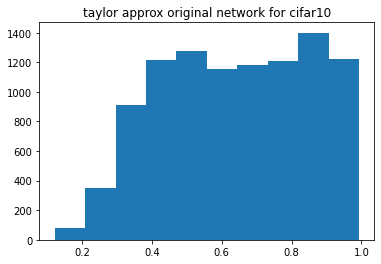

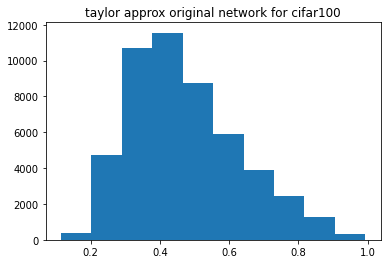

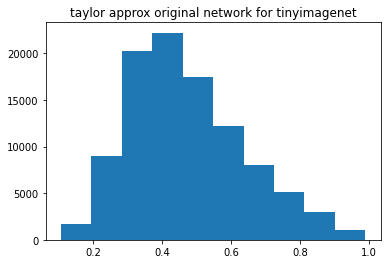

In [14]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(testloader, net, device, plt_title="taylor approx original network for cifar10")
maxclass_hist(stealloader, net, device, plt_title="taylor approx original network for cifar100")
maxclass_hist(outlier_loader, net, device, plt_title="taylor approx original network for tinyimagenet")

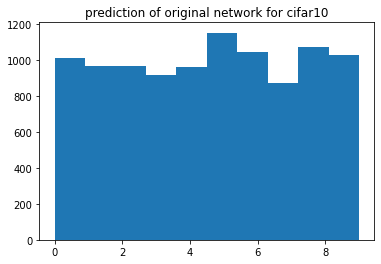

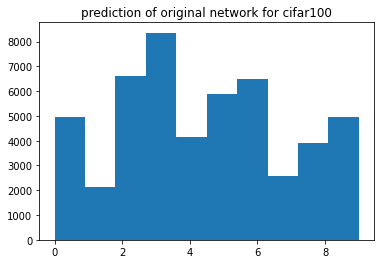

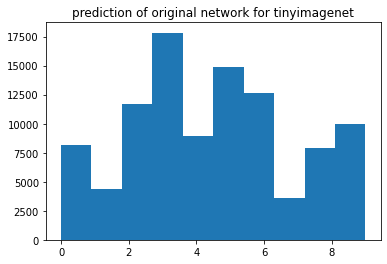

In [16]:
prediction_hist(testloader, net, device, plt_title="prediction of original network for cifar10")
prediction_hist(stealloader, net, device, plt_title="prediction of original network for cifar100")
prediction_hist(outlier_loader, net, device, plt_title="prediction of original network for tinyimagenet")

## Outlier Exposure

In [11]:
import copy
from utils import train_model_with_oe_KL

In [12]:
net_oe = copy.deepcopy(net)

In [13]:
loss_in = nn.NLLLoss()
loss_out = nn.KLDivLoss(reduction='batchmean')
optimizer_oe = optim.Adam(net_oe.parameters(), lr=0.0001)

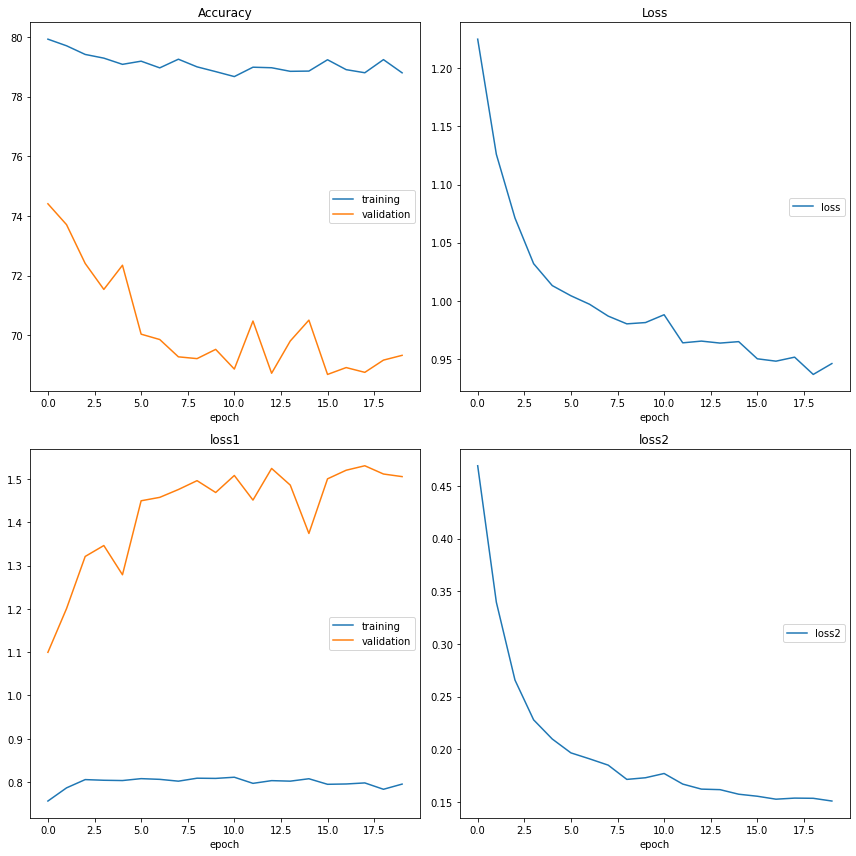

Accuracy
	training         	 (min:   78.674, max:   79.928, cur:   78.800)
	validation       	 (min:   68.690, max:   74.410, cur:   69.330)
Loss
	loss             	 (min:    0.937, max:    1.225, cur:    0.946)
loss1
	training         	 (min:    0.756, max:    0.811, cur:    0.795)
	validation       	 (min:    1.100, max:    1.531, cur:    1.505)
loss2
	loss2            	 (min:    0.151, max:    0.469, cur:    0.151)


In [14]:
## oe loss 가중치 얼마줄 것인가를 weight_out 에서 조정!
net_oe, logs_oe = train_model_with_oe_KL(net_oe, trainloader, outlier_loader, optimizer_oe, device, 
                          loss_in, loss_out, weight_out=0.1, epochs=20,pred_prob = True, test_loader = testloader,
                          save_dir = '../results', save_model="cifar_oe_net.pth")

### Load model

In [26]:
net_oe = Net()
net_oe.load_state_dict(torch.load(os.path.join("../results","cifar_oe_net.pth")))

<All keys matched successfully>

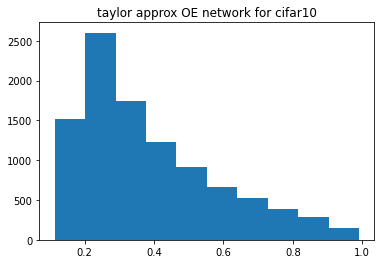

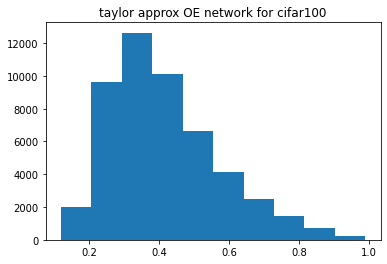

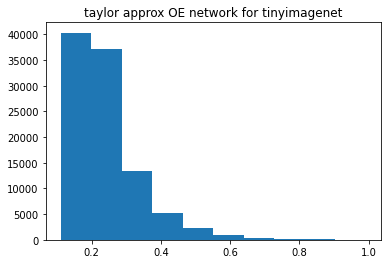

In [15]:
from utils import maxclass_hist, prediction_hist

maxclass_hist(testloader, net_oe, device, plt_title="taylor approx OE network for cifar10")
maxclass_hist(stealloader, net_oe, device, plt_title="taylor approx OE network for cifar100")
maxclass_hist(outlier_loader, net_oe, device, plt_title="taylor approx OE network for tinyimagenet")

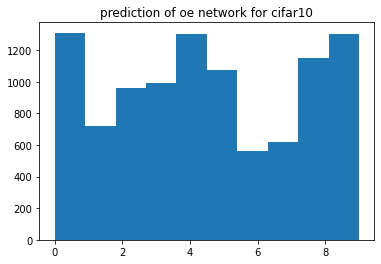

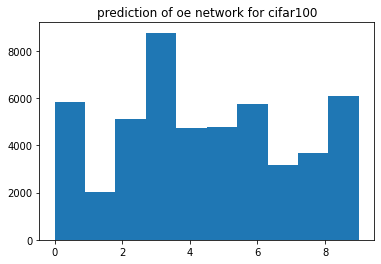

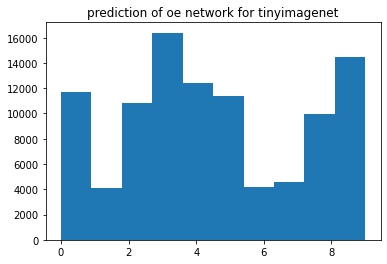

In [16]:
prediction_hist(testloader, net_oe, device, plt_title="prediction of oe network for cifar10")
prediction_hist(stealloader, net_oe, device, plt_title="prediction of oe network for cifar100")
prediction_hist(outlier_loader, net_oe, device, plt_title="prediction of oe network for tinyimagenet")

# Train Fake Net

## Taylor NLL + SWAE

In [12]:
from utils import train_swd_fakenet_NLL, make_st_loader

In [13]:
fake_swd = Net()
optim_swd = optim.Adam(fake_swd.parameters(),lr=0.0001)

In [14]:
st_loader = make_st_loader(net, trainloader, device)

In [15]:
fake_swae, fake_logs = train_swd_fakenet_NLL(fake_swd, trainloader, st_loader, optim_swd,device, epochs=30, 
                                             loss_weights=1., test_loader = testloader,
                                             save_dir = '../results',save_model="cifar_fake_taylor_swae.pth")

0 {'acc': tensor(5.8580), 'loss': tensor(0.0932), 'loss1': tensor(0.0779), 'loss2': tensor(0.0153), 'val_loss1': tensor(0.0521), 'val_acc': tensor(2.8100)}
1 {'acc': tensor(2.8880), 'loss': tensor(0.0552), 'loss1': tensor(0.0478), 'loss2': tensor(0.0074), 'val_loss1': tensor(0.0417), 'val_acc': tensor(2.1400)}
2 {'acc': tensor(2.3480), 'loss': tensor(0.0473), 'loss1': tensor(0.0401), 'loss2': tensor(0.0071), 'val_loss1': tensor(0.0337), 'val_acc': tensor(1.6400)}
3 {'acc': tensor(1.8360), 'loss': tensor(0.0402), 'loss1': tensor(0.0333), 'loss2': tensor(0.0068), 'val_loss1': tensor(0.0330), 'val_acc': tensor(1.6500)}
4 {'acc': tensor(1.6000), 'loss': tensor(0.0366), 'loss1': tensor(0.0300), 'loss2': tensor(0.0066), 'val_loss1': tensor(0.0273), 'val_acc': tensor(1.5700)}
5 {'acc': tensor(1.4680), 'loss': tensor(0.0340), 'loss1': tensor(0.0279), 'loss2': tensor(0.0061), 'val_loss1': tensor(0.0263), 'val_acc': tensor(1.3700)}
6 {'acc': tensor(1.4280), 'loss': tensor(0.0326), 'loss1': tenso

### load model

In [15]:
import os
fake_swd.load_state_dict(torch.load(os.path.join("../results","cifar_fake_taylor_swae.pth")))

<All keys matched successfully>

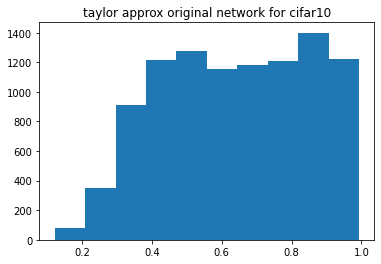

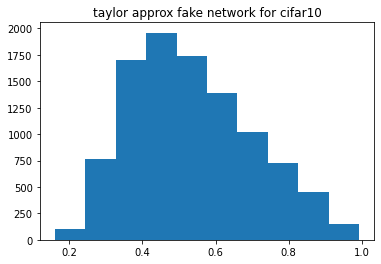

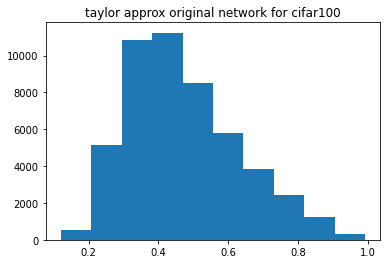

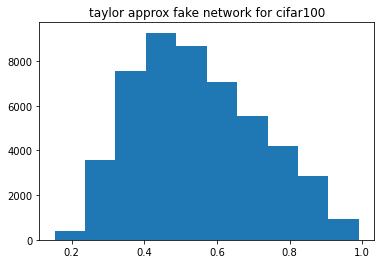

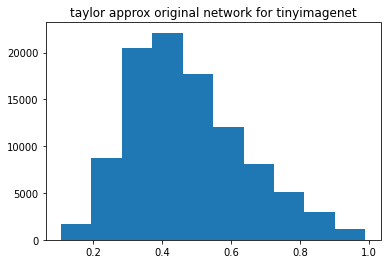

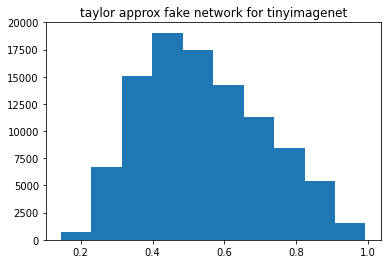

In [28]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(testloader, net, device, plt_title="taylor approx original network for cifar10")
maxclass_hist(testloader, fake_swd, device, plt_title="taylor approx fake network for cifar10")

maxclass_hist(stealloader, net, device, plt_title="taylor approx original network for cifar100")
maxclass_hist(stealloader, fake_swd, device, plt_title="taylor approx fake network for cifar100")

maxclass_hist(outlier_loader, net, device, plt_title="taylor approx original network for tinyimagenet")
maxclass_hist(outlier_loader, fake_swd, device, plt_title="taylor approx fake network for tinyimagenet")

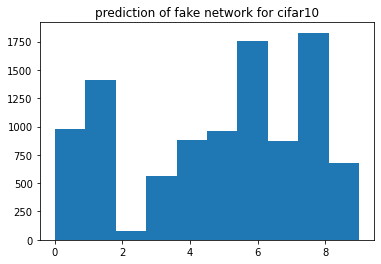

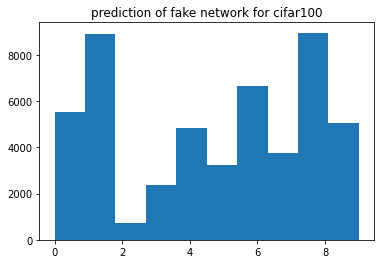

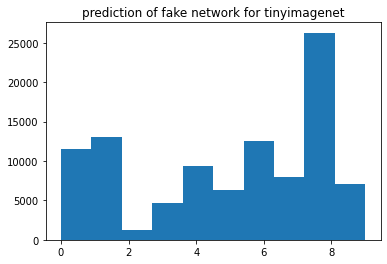

In [29]:
prediction_hist(testloader, fake_swd, device, plt_title="prediction of fake network for cifar10")
prediction_hist(stealloader, fake_swd, device, plt_title="prediction of fake network for cifar100")
prediction_hist(outlier_loader, fake_swd, device, plt_title="prediction of fake network for tinyimagenet")

## Taylor NLL with random label

In [30]:
from utils import make_randomlabel, train_model_NLL

In [31]:
net_random = Net()

In [32]:
random_loader = make_randomlabel(trainloader)
net_optim = optim.Adam(net_random.parameters(), lr=0.0001)

/home/srp/research/HEML/HEDL_inference/codes/utils/data_utils.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  randset = torch.utils.data.TensorDataset(torch.tensor(train_all[0]),randlabel.type(torch.LongTensor))


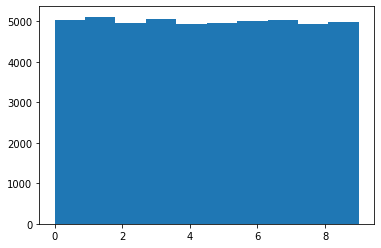

In [37]:
import matplotlib.pyplot as plt
plt.hist(random_loader.dataset.tensors[1].numpy())
plt.show()

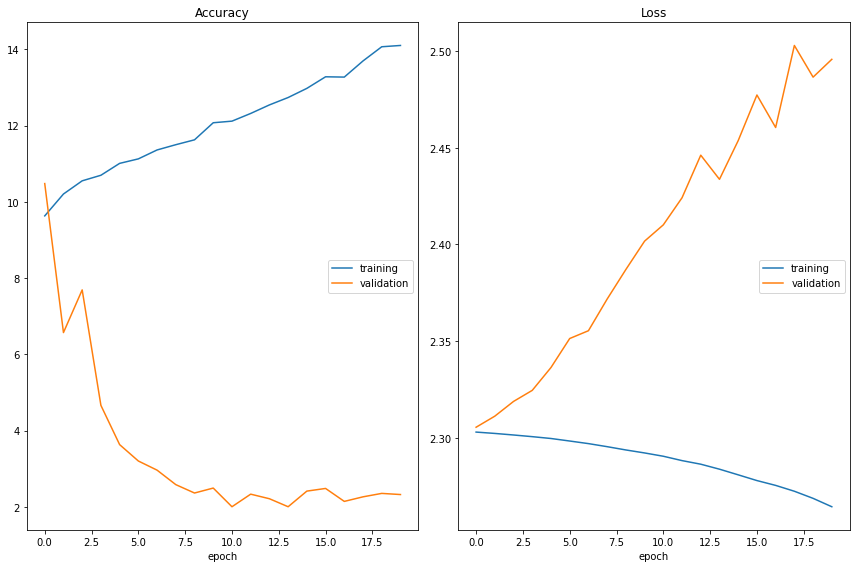

Accuracy
	training         	 (min:    9.632, max:   14.104, cur:   14.104)
	validation       	 (min:    2.000, max:   10.480, cur:    2.320)
Loss
	training         	 (min:    2.264, max:    2.303, cur:    2.264)
	validation       	 (min:    2.305, max:    2.503, cur:    2.496)


In [38]:
net_random, logs_net = train_model_NLL(net_random, random_loader, net_optim, device, epochs=20, 
                 test_loader = testloader, save_dir = "../results",save_model="cifar_fake_random_net.pth")

### load model

In [60]:
import os
net_random.load_state_dict(torch.load(os.path.join("../results","cifar_fake_random_net.pth")))

<All keys matched successfully>

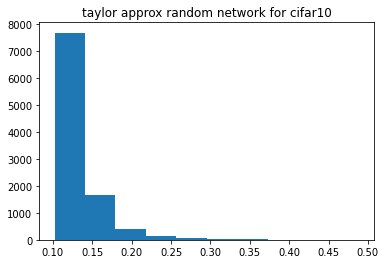

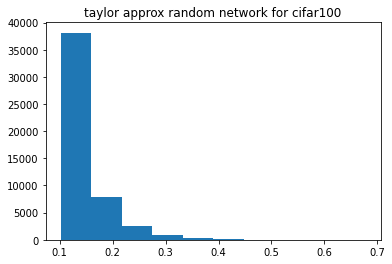

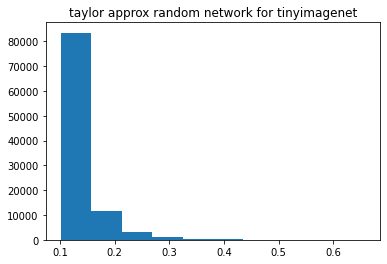

In [39]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(testloader, net_random, device, plt_title="taylor approx random network for cifar10")
maxclass_hist(stealloader, net_random, device, plt_title="taylor approx random network for cifar100")
maxclass_hist(outlier_loader, net_random, device, plt_title="taylor approx random network for tinyimagenet")

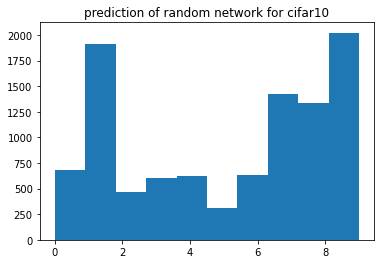

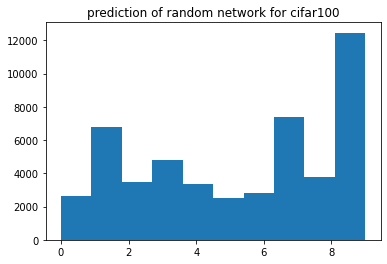

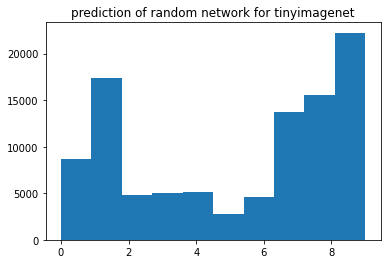

In [40]:
prediction_hist(testloader, net_random, device, plt_title="prediction of random network for cifar10")
prediction_hist(stealloader, net_random, device, plt_title="prediction of random network for cifar100")
prediction_hist(outlier_loader, net_random, device, plt_title="prediction of random network for tinyimagenet")